In [2]:
import os,sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats

%matplotlib inline
%precision 4
plt.style.use('bmh')

## Coin toss

In [3]:
n = 100
h = 61
alpha = 2
beta = 2

niter = 1000
with pm.Model() as model: # context management
    # define priors
    p = pm.Beta('p', alpha=alpha, beta=beta)

    # define likelihood
    y = pm.Binomial('y', n=n, p=p, observed=h)

    # inference
    start = pm.find_MAP() # Use MAP estimate (optimization) as the initial state for MCMC
    step = pm.Metropolis() # Have a choice of samplers
    trace = pm.sample(niter, step, start, random_seed=123, progressbar=True)

Applied logodds-transform to p and added transformed p_logodds_ to model.
100%|██████████| 1000/1000 [00:01<00:00, 882.61it/s]


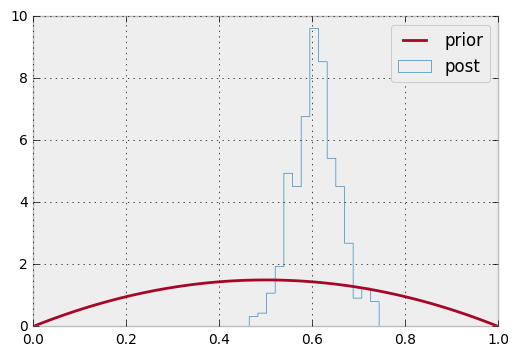

In [4]:
plt.hist(trace['p'], 15, histtype='step', normed=True, label='post');
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, alpha, beta), label='prior');
plt.legend(loc='best');